Install and import dependencies

In [1]:
#import dependecies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

Build data loading function

In [2]:
Capuchin_File = os.path.join('data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
Not_Capuchin_File = os.path.join('data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [4]:
def load_wav_16k_mono(filename):
    #load contents of file
    file_contents = tf.io.read_file(filename)

    #decode file
    wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)

    #remove trailing axis
    wav = tf.squeeze(wav,axis=1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    #Goes from 44100HZ to 16000HZ
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [5]:
#plot a wave

wav_capuchin = load_wav_16k_mono(Capuchin_File)
wav_not_capuchin = load_wav_16k_mono(Not_Capuchin_File)


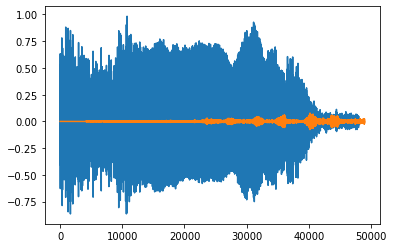

In [6]:
plt.plot(wav_capuchin)
plt.plot(wav_not_capuchin)
plt.show()